In [24]:
import numpy as np
import matplotlib.pyplot as plt
import openqcs as o
import openqcs.tools as t
import openqcs.spinchain as sp
import openqcs.statistic as st
import openqcs.iterativ as it
import openqcs.qcirc as qc
import pyqcs as p
from pyqcs import H, X, R

In [18]:
class State:
    def __init__(self, psi):
        self.qm = psi
        self.vec = np.matrix([p for p in psi._qm_state]).H
        self.rho = self.vec @ self.vec.H
        
        

psi = State(p.State.new_zero_state(1))
print(psi.rho)


[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [71]:
def walk_a_path(iSt, N, T):
    state = State(iSt)
    
    path=""
    
    for i in range(N):
        rho_in = state.rho
        Ks = o.get_kraus_(T)
        rho_out = o.channel_(rho_in, Ks)
        
        p, E0, E1, msg = it.it_kraus(rho_in, rho_out)
        #print(p)
        
        if msg["ier"] == False:
            raise ValueError()
            
        # Draw our fate, 0 <= q <= 1
        q = np.random.rand()
        
        if q < p:
            # go path 0
            circ = qc.u2_to_circuit(0,t.get_u2_param(E0))
            state = State(circ*state.qm)
            path+="0"
        else:
            # go path 1
            circ = qc.u2_to_circuit(0,t.get_u2_param(E1))
            state = State(circ*state.qm)
            path+="1"
    #print(path)
            
    return state.qm

def sample_paths(iSt, N_samples, N_time, T):
    
    mRes = np.zeros((N_samples, 2), dtype=np.double)
    
    for i in range(N_samples):
        psi = walk_a_path(iSt, N_time, T)
        
        for j, v in enumerate(psi._qm_state):
            mRes[i,j] = np.double(v*np.conj(v))
            
    result = [st.bootstrap(mRes[:,0]), st.bootstrap(mRes[:,1])]
    return np.array(result)

def evolution(H, iSt, t_max, dt, N_samples=100):
    N_times = int(t_max/dt)
    T = sp.T_(H, dt)
    t.color_matrix(T)
    
    init_state = State(iSt)
    
    data = np.zeros((N_times+1,2,2), dtype=np.double)
    data_cl = np.zeros((N_times+1,2), dtype=np.double)
    
    tdata = np.arange(N_times+1)*dt
    data[0,:,:] = [[np.abs(iSt._qm_state[0]),0.0],
                  [np.abs(iSt._qm_state[1]),0.0]]
    
    data_cl[0,:] = [np.abs(iSt._qm_state[i]) for i in range(2)]
    
    for n in range(1,N_times+1):
        print("{} of {}".format(n, N_times))
        print("t = {}".format(n*dt))
        
        data[n,:,:] = sample_paths(iSt, N_samples, n, T)
        
        Ks = o.get_kraus_(T**n)
        rho = o.channel_(init_state.rho, Ks)
        data_cl[n,:] = [rho[0,0].real, rho[1,1].real]
        
    return tdata, data, data_cl
        
        
        
        
        
    

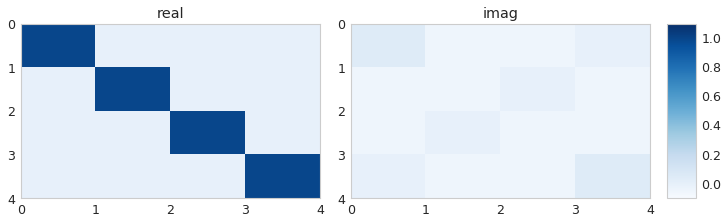

1 of 50
t = 0.1
2 of 50
t = 0.2


/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


3 of 50
t = 0.30000000000000004
4 of 50
t = 0.4
5 of 50
t = 0.5
6 of 50
t = 0.6000000000000001
7 of 50
t = 0.7000000000000001
8 of 50
t = 0.8
9 of 50
t = 0.9
10 of 50
t = 1.0
11 of 50
t = 1.1
12 of 50
t = 1.2000000000000002
13 of 50
t = 1.3
14 of 50
t = 1.4000000000000001
15 of 50
t = 1.5
16 of 50
t = 1.6
17 of 50
t = 1.7000000000000002
18 of 50
t = 1.8
19 of 50
t = 1.9000000000000001
20 of 50
t = 2.0


/home/andreas/anaconda3/lib/python3.7/site-packages/pyqcs/gates/gate.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  BaseGate.__init__(self, BasicGate(type_, act, control, r, numpy.random.uniform))


21 of 50
t = 2.1
22 of 50
t = 2.2
23 of 50
t = 2.3000000000000003
24 of 50
t = 2.4000000000000004
25 of 50
t = 2.5
26 of 50
t = 2.6
27 of 50
t = 2.7
28 of 50
t = 2.8000000000000003
29 of 50
t = 2.9000000000000004
30 of 50
t = 3.0
31 of 50
t = 3.1
32 of 50
t = 3.2
33 of 50
t = 3.3000000000000003
34 of 50
t = 3.4000000000000004
35 of 50
t = 3.5
36 of 50
t = 3.6
37 of 50
t = 3.7
38 of 50
t = 3.8000000000000003
39 of 50
t = 3.9000000000000004
40 of 50
t = 4.0
41 of 50
t = 4.1000000000000005
42 of 50
t = 4.2
43 of 50
t = 4.3
44 of 50
t = 4.4
45 of 50
t = 4.5
46 of 50
t = 4.6000000000000005
47 of 50
t = 4.7
48 of 50
t = 4.800000000000001
49 of 50
t = 4.9
50 of 50
t = 5.0


In [78]:
a = 0.5
b = 0.5
dt = 0.1
t_max = 5.0

Ham = sp.H_(a,b)
iSt = p.State.new_zero_state(1)

tdata, data, data_cl = evolution(Ham, iSt, t_max, dt)


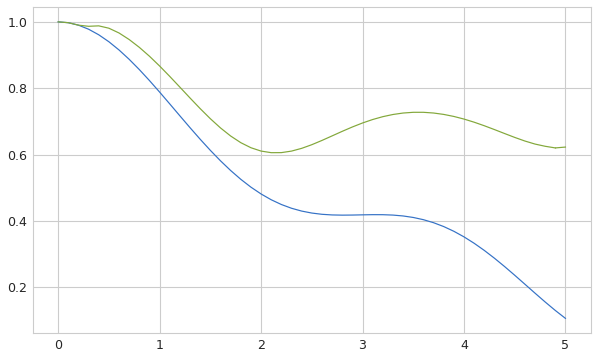

In [79]:
plt.figure(figsize=(10,6))
plt.plot(tdata, data_cl[:,0])
plt.errorbar(tdata, data[:,0,0], yerr=data[:,0,1])
plt.show()

In [77]:
print(data[:,0])

[[1. 0.]
 [1. 0.]]
